<a href="https://www.kaggle.com/code/brunorateiro/detroit-blight-ticket-compliance?scriptVersionId=119365042" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

According to [this CNBC article](https://www.cnbc.com/2014/05/28/eliminating-blight-could-cost-bankrupt-detroit-more-than-850-million.html), eliminating blight in the city of Detroit is estimated to cost \$850 million. Fines are issued to infractors, but many remain unpaid. Motivated by a [competition](https://www.kaggle.com/competitions/detroit-blight-ticket-compliance/overview) that took place six ago, this study tackles blight ticket compliance.

We will read, format and analyse two data sets containing training and test data seperately. The first data set will be used to fit various machine learning models, evaluated using a [AUC-ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) criteria. The latter will be used to predict if blight ticket will be paid on time.

The minimum expected AUC-ROC score is 0.75. The classifier that has the better score will then be used to judge the relevance of the features selected, as some might have a bigger impact on compliance.

As there are two categories for our prediction target - will the blight ticket be paid on time or not: this is a binary classification problem.

<div style="width:100%;text-align: center;"> <img align=middle src="https://image.cnbcfm.com/api/v1/image/101425482-DetroitWinter8.jpg?v=1394564303&w=630&h=354" alt="Heat beating" style="height:300px;margin-top:1rem;margin-bottom:1rem;"> </div>

## Table of contents <a id="ToC"></a>
* [1. Data preprocessing](#1)
    * [1.1 Importing libraries](#1.1)
    * [1.2 Data reading](#1.2)
    * [1.3 Combining DataFrames](#1.3)
    * [1.4 Primary features selection](#1.4)
    * [1.5 Feature engineering](#1.5)
        * [1.5.1 Violation code](#1.5.1)
        * [1.5.2 Disposition](#1.5.2)
        * [1.5.3 Fee or discount](#1.5.3)


* [2. Exploratory data analysis (EDA)](#2)
    * [2.1 Categorical features summary](#2.1)
    * [2.2 Numerical features summary](#2.2)
    * [2.3 Violation code](#2.3)
    * [2.4 Agency name](#2.4)
    * [2.5 Disposition](#2.5)
    * [2.6 Judgment amount](#2.6)
    * [2.7 Fee or discount](#2.7)
    * [2.8 Latitude and Longitude](#2.8)


* [3. Machine learning](#3)
    * [3.1 Predictor variables and target variable](#3.1)
    * [3.2 Feature encoding](#3.2)
    * [3.3 Data split](#3.3)
    * [3.4 Model training and pipelines](#3.4)
        * [3.4.1 K-nearest neighbors](#3.4.1)
        * [3.4.2 Logistic regression](#3.4.2)
        * [3.4.3 Support vector machine](#3.4.3)
        * [3.4.4 Random forests](#3.4.4)
    * [3.5 Feature importance](#3.5)
    * [3.6 ROC curve](#3.6)
    * [3.7 Applying best classifier to test data](#3.7)
    
    
* [4. Conclusion](#4)

# 1. Data preprocessing <a id="1"></a>
[ToC](#ToC) | [Next](#1.1)

In this section relevant libraries used are listed, data is read and combined into different datasets, primary features are selected and then some features are transformed into more informative features.

## 1.1 Importing libraries <a id="1.1"></a> 
[Previous](#1) | [ToC](#ToC) | [Next](#1.2)

All imports used throughout the study are listed below.

In [1]:
# Data wrangling
import numpy as np 
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Machine learning settings
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Machine learning classifiers and model selection
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Machine learning metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

## 1.2 Data reading <a id="1.2"></a> 
[Previous](#1.1) | [ToC](#ToC) | [Next](#1.3)

The main data sets considered in this study are:
* **training_data** (from *train.csv*): training set, containing tickets issued from 2004 to 2011;
* **test_data** (from *test.csv*): test set, containing tickets issued from 2012 to 2016.

Two complementary data sets that combined provides geographic information:
* **adresses** (from *addresses.csv*): mapping from ticket id to addresses;
* **coordinates** (from *latlons.csv*): mapping from addresses to latitude and longitude coordinates.

In [2]:
# Reading training set
training_data = pd.read_csv('/kaggle/input/detroit-blight-ticket/train.csv',
                           index_col='ticket_id',                           
                           encoding="ISO-8859-1",
                           low_memory=False)
training_data.name = 'training_data'

# Reading test set
test_data = pd.read_csv('/kaggle/input/detroit-blight-ticket/test.csv',
                       index_col='ticket_id')
test_data.name = 'test_data'

# Reading addresses
addresses = pd.read_csv('/kaggle/input/detroit-blight-ticket/addresses.csv')
addresses.name = 'addresses'

# Reading coordinates
coordinates = pd.read_csv('/kaggle/input/detroit-blight-ticket/latlons.csv')
coordinates.name = 'coordinates'

In [3]:
def columns(df):
    """From a dataframe df, get a report of column names"""
    
    columns = ', '.join(df.columns)
    length = len(df.columns)
    plural = 's' if length-1 else ''
    
    print(f"DataFrame '{df.name}' has {length} column{plural}: \n"+ columns+'.\n')
    
for df in [training_data, test_data, addresses, coordinates]:
    columns(df)

DataFrame 'training_data' has 33 columns: 
agency_name, inspector_name, violator_name, violation_street_number, violation_street_name, violation_zip_code, mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country, ticket_issued_date, hearing_date, violation_code, violation_description, disposition, fine_amount, admin_fee, state_fee, late_fee, discount_amount, clean_up_cost, judgment_amount, payment_amount, balance_due, payment_date, payment_status, collection_status, grafitti_status, compliance_detail, compliance.

DataFrame 'test_data' has 26 columns: 
agency_name, inspector_name, violator_name, violation_street_number, violation_street_name, violation_zip_code, mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country, ticket_issued_date, hearing_date, violation_code, violation_description, disposition, fine_amount, admin_fee, state_fee, late_fee, discount_amount, clean_up_cost, judgment_amount, g

## 1.3 Combining DataFrames <a id="1.3"></a> 
[Previous](#1.2) | [ToC](#ToC) | [Next](#1.4) 

Before starting our analysis, *addresses* and *coordinates* combined will map latitude and longitude from ticket IDs for both *training_data* and *test_data*.

In [4]:
# Combining 'addresses' and 'coordinates' to create a 'mapping' DataFrame
mapping = addresses.merge(coordinates,
                         how='left',
                         on='address',
                         validate='m:1')
mapping.set_index('ticket_id',
                 inplace=True)

# Checking how many addresses didn't get coordinates mapped
mapping[mapping.lat.isnull() | mapping.lon.isnull()]

,address,lat,lon
ticket_id,,,
89535,"20424 bramford, Detroit MI",NaN,NaN
223598,"445 fordyce, Detroit MI",NaN,NaN
280256,"8300 fordyce, Detroit MI",NaN,NaN
317124,"20424 bramford, Detroit MI",NaN,NaN
329689,"8325 joy rd, Detroit MI 482O4",NaN,NaN
329393,"1201 elijah mccoy dr, Detroit MI 48208",NaN,NaN
333990,"12038 prairie, Detroit MI 482O4",NaN,NaN
367165,"6200 16th st, Detroit MI 482O8",NaN,NaN


In [5]:
# There are seven addresses that didn't get coordinates mapped, so we will correct it manually
addresses_and_coordinates = {'20424 bramford, Detroit MI':[42.446541, -83.023300],
                             '8300 fordyce, Detroit MI':[42.383251, -83.058189],
                             '445 fordyce, Detroit MI':[42.328590, -83.051460],
                             '8325 joy rd, Detroit MI 482O4':[42.358910, -83.151329],
                             '1201 elijah mccoy dr, Detroit MI 48208':[42.35891, -83.08291],
                             '12038 prairie, Detroit MI 482O4':[42.37675, -83.14319],
                             '6200 16th st, Detroit MI 482O8':[42.35995, -83.09583]}

for adr, crd in addresses_and_coordinates.items():
    mapping.loc[mapping.address==adr, ['lat', 'lon']] = crd

# Check if all entries are non-null
mapping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311307 entries, 22056 to 369851
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   address  311307 non-null  object 
 1   lat      311307 non-null  float64
 2   lon      311307 non-null  float64
dtypes: float64(2), object(1)
memory usage: 9.5+ MB


In [6]:
# Combining 'mapping' with both 'training_data' and 'test_data'
training_mapped_data = training_data.join(mapping, how='left')
training_mapped_data.name = 'training_mapped_data'

test_mapped_data = test_data.join(mapping, how='left')
test_mapped_data.name = 'test_mapped_data'

## 1.4 Primary features selection <a id="1.4"></a>
[Previous](#1.3) | [ToC](#ToC) | [Next](#1.5)

Not all columns available in both *test_data* and *training_data* will be considered features. Discarding columns that will not be considered as features beforehand will reduce data cleaning complexity. Some primary features will need further feature engineerting before proceding to evaluation and machine learning.

The following table illustrates the process of choosing primary features.

| Column                      | Dtype   | Both | Description                                         | Feature | Reason |
| :-------------------------- | :-----: | :--: | :---------------------------------------------------| :-----: | :-- |
| agency_name                 | object  | ✔️   | Agency that issued the ticket                       | ✅     | 
| inspector_name              | object  | ✔️   | Name of inspector that issued the ticket            | 🔲     | Only 26% of inspectors appear in both test and training sets
| violator_name               | object  | ✔️   | Name of the infractor that the ticket was issued to | 🔲     | Only 2.8% of violators appear in both test and training sets
| violation_street_number     | float64 | ✔️   | Address where the violation occurred                | 🔲     | Mapped by latitude and longitude
| violation_street_name       | object  | ✔️   | Street where the violation occurred                 | 🔲     | Mapped by latitude and longitude
| violation_zip_code          | float64 | ✔️   | Zip code where the violation occurred               | 🔲     | Mapped by latitude and longitude
| mailing_address_str_number  | float64 | ✔️   | Mailing address of the violator                     | 🔲     | Mailing information not considered
| mailing_address_str_name    | object  | ✔️   | Mailing street of the violator                      | 🔲     | Mailing information not considered
| city                        | object  | ✔️   | Mailing city of the violator                        | 🔲     | Mailing information not considered
| state                       | object  | ✔️   | Mailing state of the violator                       | 🔲     | Mailing information not considered
| zip_code                    | object  | ✔️   | Mailing zip code of the violator                    | 🔲     | Mailing information not considered
| non_us_str_code             | object  | ✔️   | Mailing non us country code of the violator         | 🔲     | Mailing information not considered
| country                     | object  | ✔️   | Country of the violator                             | 🔲     | Mailing information not considered
| ticket_issued_date          | object  | ✔️   | Date and time the ticket was issued                 | 🔲     | This information alone is not descriptive
| hearing_date                | object  | ✔️   | Date and time the violator's hearing was scheduled  | 🔲     | A third is missing from test data
| violation_code              | object  | ✔️   | Type of violation                                   | ✅     | Some filtering is needed to combine code classes
| violation_description       | object  | ✔️   | Violation description                               | 🔲     | Target information encoded in *violation_code*
| disposition                 | object  | ✔️   | Judgment and judgement type                         | ✅     |
| fine_amount                 | float64 | ✔️   | Violation fine amount, excluding fees               | 🔲     | Part of *judment_amount*
| admin_fee                   | float64 | ✔️   | \$20 fee assigned to responsible judgments          | 🔲     | Constant to all violators deemed responsible
| state_fee                   | float64 | ✔️   | \$10 fee assigned to responsible judgments          | 🔲     | Constant to all violators deemed responsible
| late_fee                    | float64 | ✔️   | 10% fee assigned to responsible judgments           | ✅     | Combined with *discount_amount* into a new feature
| discount_amount             | float64 | ✔️   | 10% discount applied                                | ✅     | Combined with *late_fee* into a new feature
| clean_up_cost               | float64 | ✔️   | DPW clean-up or graffiti removal cost               | 🔲     | Constant zero to all training data
| judgment_amount             | float64 | ✔️   | Sum of all fines and fees                           | ✅     |
| payment_amount              | float64 | ❌   | Amount paid, if any                                 | 🔲     | Information not available at test-time
| balance_due                 | float64 | ❌   | Fines and fees still owed                           | 🔲     | Information not available at test-time
| payment_date                | object  | ❌   | Date payment was made, if it was received           | 🔲     | Information not available at test-time
| payment_status              | object  | ❌   | Current payment status as of February 1st 2017      | 🔲     | Irrelevant for new tickets
| collection_status           | object  | ❌   | Flag for payments in collections                    | 🔲     | Information not available at test-time
| grafitti_status             | object  | ✔️   | Flag for graffiti violations                        | 🔲     | Appears only once in training data
| compliance_detail           | object  | ❌   | Information on why it was/wasn't marked compliant   | 🔲     | Target information encoded in *compliance*
| compliance                  | float64 | ❌   | **Target variable for prediction**                  | ☑️     |
| address                     | object  | ✔️   | Full address where the violation occurred           | 🔲     | Mapped by latitude and longitude
| lat                         | float64 | ✔️   | Latitude where the violation occurred               | ✅     |
| lon                         | float64 | ✔️   | Longitude where the violation occurred              | ✅     |

Our target variable for prediction *compliance* has three states in *training_mapped_data*:
* **Null:** Not responsible;
* **0:** Responsible and non-compliant;
* **1:** Responsible and compliant

In order to analyse compliance, only violators deemed responsible are going to be considered.

In [7]:
# Selecting primary features before any feature engineering
primary_features = ['violation_code', 'agency_name', 'disposition', 'judgment_amount', 'late_fee', 'discount_amount', 'lat', 'lon']
target = ['compliance']

# Removing instances deemed not responsible
training_mapped_data.dropna(subset=['compliance'], inplace=True) 

# Checking type and if there are null primary feature values for both datasets
for df in [training_mapped_data, test_mapped_data]:
    print(f"Information about '{df.name}' DataFrame:")
    df[primary_features].info()
    print('\n')

# Visualizing primary features and target in training data
training_mapped_data.loc[:,primary_features+target]

Information about 'training_mapped_data' DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 22056 to 284333
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   violation_code   159880 non-null  object 
 1   agency_name      159880 non-null  object 
 2   disposition      159880 non-null  object 
 3   judgment_amount  159880 non-null  float64
 4   late_fee         159880 non-null  float64
 5   discount_amount  159880 non-null  float64
 6   lat              159880 non-null  float64
 7   lon              159880 non-null  float64
dtypes: float64(5), object(3)
memory usage: 11.0+ MB


Information about 'test_mapped_data' DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61001 entries, 284932 to 369851
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   violation_code   61001 non-null  object 
 1   agen

,violation_code,agency_name,disposition,judgment_amount,late_fee,discount_amount,lat,lon,compliance
ticket_id,,,,,,,,,
22056,9-1-36(a),"Buildings, Safety Engineering & Env Department",Responsible by Default,305.0,25.0,0.0,42.390729,-83.124268,0.0
27586,61-63.0600,"Buildings, Safety Engineering & Env Department",Responsible by Determination,855.0,75.0,0.0,42.326937,-83.135118,1.0
22046,9-1-36(a),"Buildings, Safety Engineering & Env Department",Responsible by Default,305.0,25.0,0.0,42.145257,-83.208233,0.0
18738,61-63.0500,"Buildings, Safety Engineering & Env Department",Responsible by Default,855.0,75.0,0.0,42.433466,-83.023493,0.0
18735,61-63.0100,"Buildings, Safety Engineering & Env Department",Responsible by Default,140.0,10.0,0.0,42.388641,-83.037858,0.0
...,...,...,...,...,...,...,...,...,...
285106,22-2-88(b),Department of Public Works,Responsible by Default,250.0,20.0,0.0,42.440228,-83.154829,0.0
284650,22-2-88(b),Department of Public Works,Responsible by Default,1130.0,100.0,0.0,42.406293,-83.171850,0.0
285125,22-2-88(b),Department of Public Works,Responsible by Default,580.0,50.0,0.0,42.366529,-83.141897,0.0


Thus, from the selected primary features three are categorical and five are numerical.

## 1.5 Feature engineering <a id="1.5"></a>
[Previous](#1.4) | [ToC](#ToC) | [Next](#1.5.1)

In this session some of the primary features are going to be transformed into more informative ones.

### 1.5.1 Violation code <a id="1.5.1"></a>
[Previous](#1.5) | [ToC](#ToC) | [Next](#1.5.2)

There are too many violation codes due to being specified down to articles for each violation code group.
We are interested in observing a broader effect of violations, therefore instances will be grouped.

Also, there are *violation_code* instances observed in *test_mapped_data* that are not present in *training_mapped_data*. Despite feature encoding dealing with this discrepancy, these instances will be renamed to *'Unknown'* in order to better illustrate data set contents during the exploratory data analysis section.


In [8]:
# List of 'violation_code' not seen during training phase, totalling of 94 instances.
unknown = '|'.join(['61-5-14', '61-85.0100', '19410901', '22-2-48', '19910901', '61-103.0100', '61-112.0100',
                    '61-14-175', '9-1-444', '61-13-102', '61-119.0100', '61-100.0100', '9-1-308', '9-1-471',
                    '9-1-218', '22-2-92', '61-5-20', '61-102.0100'])

suffixes = '|'.join(["[(].*", " .*", "[/].*"])

for df in [training_mapped_data, test_mapped_data]:
    df['violation_code_group'] = df.violation_code.str.replace(suffixes, "", regex=True)
    
test_mapped_data['violation_code_group'] = test_mapped_data.violation_code_group.str.replace(unknown, "Unknown", regex=True)

# Frequency table for different violation code groups
violation_code_group = pd.DataFrame([training_mapped_data.violation_code_group.value_counts(normalize=True),
                                     test_mapped_data.violation_code_group.value_counts(normalize=True)]).T
violation_code_group.columns = ['training', 'test']
violation_code_group.fillna(value=0, inplace=True)
violation_code_group

,training,test
9-1-36,0.403059,0.142080
22-2-88,0.151282,0.279143
9-1-81,0.144859,0.026377
9-1-104,0.105873,0.266537
22-2-45,0.026270,0.046622
...,...,...
9-1-462,0.000006,0.000000
9-1-474,0.000006,0.000000
9-1-353,0.000006,0.000016
20160901,0.000006,0.000000


Even though there is a significant decrease in *violation_group* categories, there are too many categories to handle in feature encoding. This might result in model overfitting.

Thus, this feature will be relabeled according to its frequency in training data.

In [9]:
# Labels and bins based on frequency for training data
labels = ['Infrequent', 'Uncommon', 'Common', 'Frequent', 'Very frequent']
bins = [0, .01, .02, 0.05, .16, .5]
frequencies = pd.cut(violation_code_group.training,
                     bins=bins,
                     right=False,
                     labels=labels)

for df in [training_mapped_data, test_mapped_data]:
    df['violation_code_frequency'] = frequencies[df.violation_code_group].to_numpy()

violation_code_frequency = pd.DataFrame([training_mapped_data.violation_code_frequency.value_counts(),
                                         test_mapped_data.violation_code_frequency.value_counts()]).T
violation_code_frequency.columns = ['training', 'test']
violation_code_frequency

,training,test
Very frequent,64441,8667
Frequent,64274,34896
Uncommon,12197,4536
Common,11393,3904
Infrequent,7575,8998


From 146 categories in training data to five frequency categories, the encoding of violation code will now generate less variables.

### 1.5.2 Disposition <a id="1.5.2"></a>
[Previous](#1.5.1) | [ToC](#ToC) | [Next](#1.5.3)

Similarly to violation code, similar dispositions will be grouped.

In [10]:
similar = {'Responsible (Fine Waived) by Deter':'Responsible by Determination',
           'Responsible - Compl/Adj by Default':'Responsible by Default',
           'Responsible - Compl/Adj by Determi':'Responsible by Determination',
           'Responsible (Fine Waived) by Admis':'Responsible by Admission',
           'Responsible by Dismissal':'Unknown'}

for df in [training_mapped_data, test_mapped_data]:
    df.disposition.replace(similar, inplace=True)

disposition = pd.DataFrame([training_mapped_data[training_mapped_data.compliance.notna()].disposition.value_counts(), test_mapped_data.disposition.value_counts()]).T
disposition.columns = ['training', 'test']
disposition

,training,test
Responsible by Default,138340.0,51608.0
Responsible by Admission,13701.0,4485.0
Responsible by Determination,7839.0,4907.0
Unknown,NaN,1.0


### 1.5.3 Fee or discount <a id="1.5.3"></a>
[Previous](#1.5.2) | [ToC](#ToC) | [Next](#2)

Both *late_fee* and *discount_amount* represent 10% of *judgment_amount*. They would apply a fee or a discount to judgment amount respectively and do not occur simutaneously in the same instance. Therefore we can reduce these two primary features into a new feature 'fee_or_discount': with three possible values:
* **Discount:** discount was applied;
* **Late fee:** late fee was applied;
* **No modifier:** no modifier.

In [11]:
modifier = {-1: 'Discount',
            0: 'No modifier',
            1: 'Late fee'}

for df in [training_mapped_data, test_mapped_data]:
    df['fee_or_discount'] = np.sign(df.late_fee-df.discount_amount).map(modifier)

training_mapped_data.fee_or_discount.value_counts()

Late fee       144422
No modifier     14278
Discount         1180
Name: fee_or_discount, dtype: int64

<a id="1.5.4"></a>
### 1.5.4 Final features

After feature engineering, we come to the following group of features.

In [12]:
features = ['violation_code_frequency', 'agency_name', 'disposition', 'judgment_amount', 'fee_or_discount', 'lat', 'lon']

# Checking type and if there are null primary feature values for both datasets
for df in [training_mapped_data, test_mapped_data]:
    print(f"Information about '{df.name}' DataFrame:")
    df[features].info()
    print('\n')

# Visualizing missing features and target values in training data
training_mapped_data.loc[:,features+target]

Information about 'training_mapped_data' DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 22056 to 284333
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   violation_code_frequency  159880 non-null  object 
 1   agency_name               159880 non-null  object 
 2   disposition               159880 non-null  object 
 3   judgment_amount           159880 non-null  float64
 4   fee_or_discount           159880 non-null  object 
 5   lat                       159880 non-null  float64
 6   lon                       159880 non-null  float64
dtypes: float64(3), object(4)
memory usage: 9.8+ MB


Information about 'test_mapped_data' DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61001 entries, 284932 to 369851
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0  

,violation_code_frequency,agency_name,disposition,judgment_amount,fee_or_discount,lat,lon,compliance
ticket_id,,,,,,,,
22056,Very frequent,"Buildings, Safety Engineering & Env Department",Responsible by Default,305.0,Late fee,42.390729,-83.124268,0.0
27586,Infrequent,"Buildings, Safety Engineering & Env Department",Responsible by Determination,855.0,Late fee,42.326937,-83.135118,1.0
22046,Very frequent,"Buildings, Safety Engineering & Env Department",Responsible by Default,305.0,Late fee,42.145257,-83.208233,0.0
18738,Infrequent,"Buildings, Safety Engineering & Env Department",Responsible by Default,855.0,Late fee,42.433466,-83.023493,0.0
18735,Infrequent,"Buildings, Safety Engineering & Env Department",Responsible by Default,140.0,Late fee,42.388641,-83.037858,0.0
...,...,...,...,...,...,...,...,...
285106,Frequent,Department of Public Works,Responsible by Default,250.0,Late fee,42.440228,-83.154829,0.0
284650,Frequent,Department of Public Works,Responsible by Default,1130.0,Late fee,42.406293,-83.171850,0.0
285125,Frequent,Department of Public Works,Responsible by Default,580.0,Late fee,42.366529,-83.141897,0.0


From the initial eight primary features, two were modified in place and other two were combined into one. From the new group of seven features, three are categorical and four are numerical. Also, there are no null values.

# 2. Exploratory data analysis (EDA) <a id="2"></a>
[Previous](#1.5.3) | [ToC](#ToC) | [Next](#2.1)

In this section, first we analyse summary statistics for both categorical and numerical features. Then we will explore how these different features influence compliance.

In [13]:
# Separate features into categorical and numerical
features_categorical = ['violation_code_frequency', 'agency_name', 'disposition', 'fee_or_discount']
features_numerical = ['judgment_amount', 'lat', 'lon']

# Setting preferences for plots
sns.set_theme(style="white", palette="deep")

## 2.1 Categorical features summary <a id="2.1"></a>
[Previous](#2) | [ToC](#ToC) | [Next](#2.2)

The table below shows summary statistics for categorical features in both training and test sets. The number of different categories in *violation_code* is far greater than the other two categorical features. In general, test set show less unique classes than training sets, except for the *'Unknown'* classes introduced during feature engineering and will be dealt with during encoding phase. As noted before, there are no null values in each category.

Each categorical feature will be explored further on its respective section.

In [14]:
training_categorical_summary = training_mapped_data[features_categorical].describe()
test_categorical_summary = test_mapped_data[features_categorical].describe()

pd.concat([training_categorical_summary, test_categorical_summary], keys=['training','test'])

violation_code_frequency  \
training count                    159880   
         unique                        5   
         top               Very frequent   
         freq                      64441   
test     count                     61001   
         unique                        5   
         top                    Frequent   
         freq                      34896   

                                                    agency_name  \
training count                                           159880   
         unique                                               5   
         top     Buildings, Safety Engineering & Env Department   
         freq                                             95863   
test     count                                            61001   
         unique                                               3   
         top                         Department of Public Works   
         freq                                             40731   

                            disposition fee_or_discount  
training count                   159880          159880  
         unique                       3               3  
         top     Responsible by Default        Late fee  
         freq                    138340          144422  
test     count                    61001           61001  
         unique                       4               3  
         top     Responsible by Default        Late fee  
         freq                     51608           52947

## 2.2 Numerical features summary <a id="2.2"></a> 
[Previous](#2.1) | [ToC](#ToC) | [Next](#2.3)

The table below shows summary statistics for numerical features in both training and test sets. 

*Compliance* is also included when summarizing training data, but it is absent from test data. Interestingly, only 7.3% of the tickets in training data have 'complied' status. This means our future machine learning models might be skewed towards prediciting non-compliance, thus making accuracy an insufficient metric.

Each numerical feature will be explored further on its respective section.

In [15]:
training_numerical_summary = training_mapped_data[features_numerical+target].describe()
test_numerical_summary = test_mapped_data[features_numerical].describe()

pd.concat([training_numerical_summary, test_numerical_summary], keys=['training','test'])

judgment_amount            lat            lon     compliance
training count    159880.000000  159880.000000  159880.000000  159880.000000
         mean        420.650218      42.389746     -83.111529       0.072536
         std         742.555062       0.037120       0.093515       0.259374
         min           0.000000      42.145257     -84.403766       0.000000
         25%         250.000000      42.364535     -83.185854       0.000000
         50%         305.000000      42.392575     -83.124517       0.000000
         75%         305.000000      42.419160     -83.033202       0.000000
         max       11030.000000      44.785389     -82.512936       1.000000
test     count     61001.000000   61001.000000   61001.000000            NaN
         mean        347.895541      42.392625     -83.117657            NaN
         std         460.058043       0.037672       0.098964            NaN
         min           0.000000      42.230964     -83.791406            NaN
         25%          85.000000      42.365163     -83.201210            NaN
         50%         250.000000      42.402047     -83.138942            NaN
         75%         305.000000      42.422812     -83.038791            NaN
         max       15558.800000      42.554454     -82.888926            NaN

## 2.3 Violation code <a id="2.3"></a> 
[Previous](#2.2) | [ToC](#ToC) | [Next](#2.4)

Even though *violation_code_frequency* is going to be used as a feature in machine learning, we start analysing compliance according to *violation_code_groups*.

In [16]:
# Get ticket count and compliance rate for training data 
violation_code_group = training_mapped_data[['violation_code_group', 'compliance']].groupby('violation_code_group').agg(['mean', 'count'])
violation_code_group = violation_code_group.droplevel(0, axis='columns')

# Get ticket count for test data
violation_code_group = violation_code_group.join(test_mapped_data.violation_code_group.value_counts()).fillna(0)

# Renaming columns and selecting dtype for plotting
violation_code_group.rename(columns={'mean': 'training_compliance_rate',
                                     'count': 'training_count',
                                     'violation_code_group': 'test_count'},
                                     inplace=True)
violation_code_group.test_count = violation_code_group.test_count.astype('int32')

# Converting training_compliane_rate to percentage
violation_code_group.training_compliance_rate *= 100

# Sorting columns in descending training count
violation_code_group.sort_values('training_count', inplace=True, ascending=False)

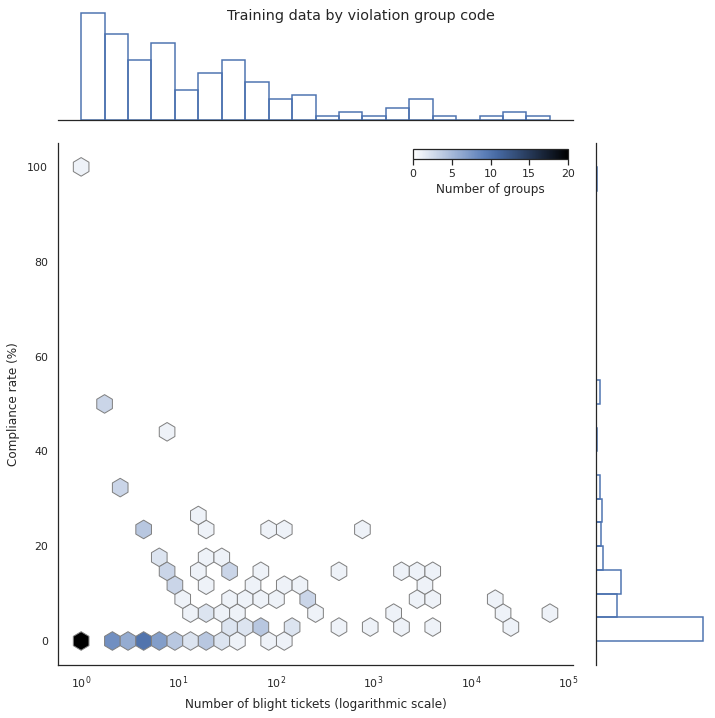

In [17]:
# Ticket count and compliance rate by violation code group in training data
hexplot = sns.jointplot(data=violation_code_group,
                        x="training_count",
                        y="training_compliance_rate",
                        ratio=4,
                        height=10,
                        kind="hex",
                        xscale='log',
                        gridsize=30,
                        mincnt=1,
                        edgecolors='gray',
                        vmin=0,
                        vmax=20,
                        marginal_kws=dict(bins=20, fill=False))

# Make auxiliary axis to insert colorbar
colorbar_axis = inset_axes(hexplot.ax_joint,
                           width="30%",
                           height="2%",
                           loc="upper right")
plt.colorbar(cax=colorbar_axis, orientation="horizontal", label='Number of groups');

# Finishing
hexplot.set_axis_labels('Number of blight tickets (logarithmic scale)', 'Compliance rate (%)', labelpad=7);
plt.suptitle('Training data by violation group code', y=.98);

Even after feature engineering, there are 146 violation code groups.
As the plot suggests, the majority of violation code groups contain only one ticket and have a compliance rate of 0%.
Between all violation code groups, the compliance rate is mainly lower than 20%.



In [18]:
# Get count and mean compliance for training data 
violation_code_frequency = training_mapped_data[['violation_code_frequency', 'compliance']].groupby('violation_code_frequency').agg(['mean', 'count'])
violation_code_frequency = violation_code_frequency.droplevel(0, axis='columns')

# Get count for test data
violation_code_frequency = violation_code_frequency.join(test_mapped_data.violation_code_frequency.value_counts()).fillna(0)

# Renaming columns for plotting
violation_code_frequency.rename(columns={'mean': 'training_compliance_rate',
                                         'count': 'training_count',
                                         'violation_code_frequency': 'test_count'},
                                inplace=True)
violation_code_frequency.test_count = violation_code_frequency.test_count.astype('int32')

# Sorting columns according to frequency labels
violation_code_frequency = violation_code_frequency.loc[labels]
violation_code_frequency

,training_compliance_rate,training_count,test_count
violation_code_frequency,,,
Infrequent,0.092541,7575,8998
Uncommon,0.111831,12197,4536
Common,0.083560,11393,3904
Frequent,0.059262,64274,34896
Very frequent,0.074037,64441,8667


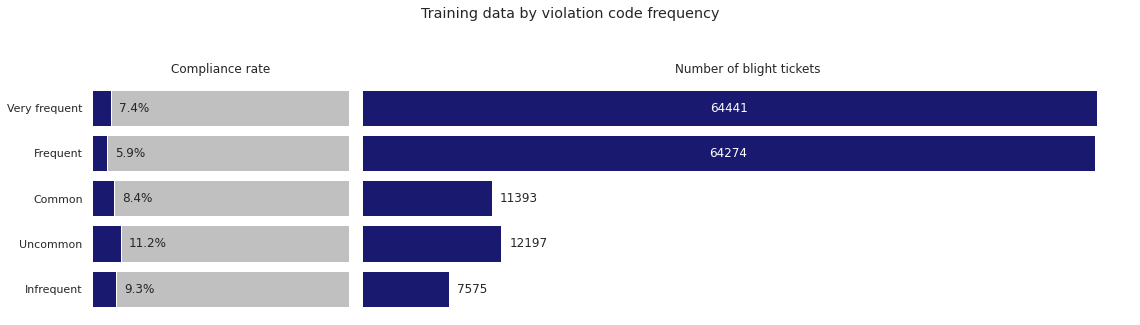

In [19]:
# Setting the plot figure
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(16,5),
                               gridspec_kw={'width_ratios': [1, 3]},
                               sharey=True)
fig.suptitle('Training data by violation code frequency', y=0.9)

# Color preference
color = 'midnightblue'

# First plot
first_bars = ax1.barh(violation_code_frequency.index, 100*violation_code_frequency.training_compliance_rate,
                      facecolor=color)

ax1.barh(violation_code_frequency.index, 100*(1-violation_code_frequency.training_compliance_rate),
         left=100*violation_code_frequency.training_compliance_rate,
         color='silver')
ax1.bar_label(first_bars, padding=8, fmt='%.1f%%')
ax1.get_xaxis().set_visible(False)
ax1.set_xlim(0,100)
ax1.set_title('Compliance rate')

# Second plot
second_bars_1 = ax2.barh(violation_code_frequency.index[3:], violation_code_frequency.training_count[3:],
                         facecolor=color)
second_bars_2 = ax2.barh(violation_code_frequency.index[:3], violation_code_frequency.training_count[:3],
                         facecolor=color)
# ax2.invert_yaxis()
ax2.bar_label(second_bars_1, label_type='center', c='w')
ax2.bar_label(second_bars_2, padding=8)
ax2.get_xaxis().set_visible(False)
ax2.set_title('Number of blight tickets')

# Finishing
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.subplots_adjust(top=.7)

There are some discrepancies between compliance rate for different violation code frequencies when compared to the total mean compliance of 7.3%, but these are not as meaninful as the other features. Thus, considering this feature into machine learning might not be as impactful as the others.

## 2.4 Agency name <a id="2.4"></a> 
[Previous](#2.3) | [ToC](#ToC) | [Next](#2.5)

In [20]:
# Get count and mean compliance for training data 
agency_name = training_mapped_data[['agency_name', 'compliance']].groupby('agency_name').agg(['mean', 'count'])
agency_name = agency_name.droplevel(0, axis='columns')

# Get count for test data
agency_name = agency_name.join(test_mapped_data.agency_name.value_counts().astype('int64')).fillna(0)

# Renaming columns and selecting dtype for plotting
agency_name.rename(columns={'mean': 'training_compliance_rate',
                            'count': 'training_count',
                            'agency_name': 'test_count'},
                   inplace=True)
agency_name.test_count = agency_name.test_count.astype('int32')

agency_name

,training_compliance_rate,training_count,test_count
agency_name,,,
"Buildings, Safety Engineering & Env Department",0.060743,95863,16832
Department of Public Works,0.089961,52445,40731
Detroit Police Department,0.131720,4464,3438
Health Department,0.065851,7107,0
Neighborhood City Halls,0.000000,1,0


All agencies in test data appear in training data. Only *'Health Department'* and *'Neighborhood City Halls'* appear in training data but not on test data. The latter appears only once in training data, and for this reason, we choose to omit it in the graphic analysis. These instances will not be excluded from the data set though, they might have relevant information regarding other features.

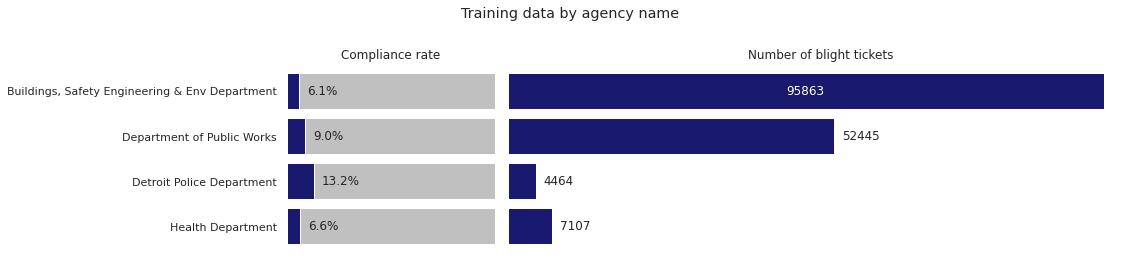

In [21]:
# Setting the plot figure
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(16,4),
                               gridspec_kw={'width_ratios': [1, 3]},
                               sharey=True)
fig.suptitle('Training data by agency name', y=0.9)

drop = agency_name.drop('Neighborhood City Halls') # Removing single instance from graph   

# Color preference
color = 'midnightblue'

# First plot
first_bars = ax1.barh(drop.index, 100*drop.training_compliance_rate,
                      facecolor=color)

ax1.barh(drop.index, 100*(1-drop.training_compliance_rate),
         left=100*drop.training_compliance_rate,
         color='silver')
ax1.bar_label(first_bars, padding=8, fmt='%.1f%%')
ax1.get_xaxis().set_visible(False)
ax1.set_xlim(0,100)
ax1.set_title('Compliance rate')

# Second plot
second_bars_1 = ax2.barh(drop.index[0], drop.training_count[0],
                         facecolor=color)
second_bars_2 = ax2.barh(drop.index[1:], drop.training_count[1:],
                         facecolor=color)
ax2.invert_yaxis()
ax2.bar_label(second_bars_1, label_type='center', c='w')
ax2.bar_label(second_bars_2, padding=8)
ax2.get_xaxis().set_visible(False)
ax2.set_title('Number of blight tickets')

# Finishing
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.subplots_adjust(top=.7)

## 2.5 Disposition <a id="2.5"></a>
[Previous](#2.4) | [ToC](#ToC) | [Next](#2.6)

In [22]:
# Get count and mean compliance for training data 
disposition = training_mapped_data[['disposition', 'compliance']].groupby('disposition').agg(['mean', 'count'])
disposition = disposition.droplevel(0, axis='columns')

# Get count for test data
disposition = disposition.join(test_mapped_data.disposition.value_counts()).fillna(0)

# Renaming columns for plotting
disposition.rename(columns={'mean': 'training_compliance_rate',
                            'count': 'training_count',
                            'disposition': 'test_count'},
                   inplace=True)
disposition.test_count = disposition.test_count.astype('int32')

# Sorting columns in descending training count
disposition.sort_values('training_count', inplace=True, ascending=False)
disposition

,training_compliance_rate,training_count,test_count
disposition,,,
Responsible by Default,0.038203,138340,51608
Responsible by Admission,0.275016,13701,4485
Responsible by Determination,0.324531,7839,4907


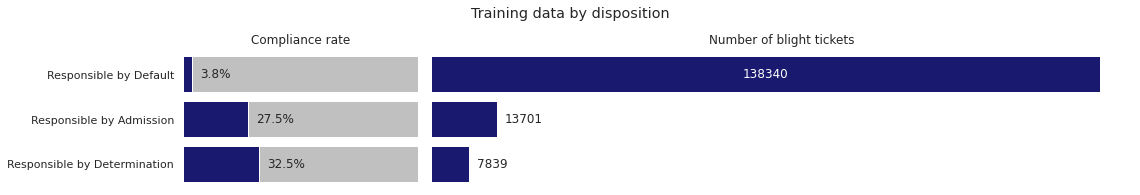

In [23]:
# Setting the plot figure
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(16,3),
                               gridspec_kw={'width_ratios': [1, 3]},
                               sharey=True)
fig.suptitle('Training data by disposition', y=0.9)

# First plot
first_bars = ax1.barh(disposition.index, 
                      100*disposition.training_compliance_rate,
                      facecolor=color)

ax1.barh(disposition.index, 
         100*(1-disposition.training_compliance_rate),
         left=100*disposition.training_compliance_rate,
         color='silver')
ax1.bar_label(first_bars, padding=8, fmt='%.1f%%')
ax1.get_xaxis().set_visible(False)
ax1.set_xlim(0,100)
ax1.set_title('Compliance rate')

# Second plot
second_bars_1 = ax2.barh(disposition.index[0],
                         disposition.training_count[0],
                         facecolor=color)
second_bars_2 = ax2.barh(disposition.index[1:],
                         disposition.training_count[1:],
                         facecolor=color)
ax2.invert_yaxis()
ax2.bar_label(second_bars_1, label_type='center', c='w')
ax2.bar_label(second_bars_2, padding=8)
ax2.get_xaxis().set_visible(False)
ax2.set_title('Number of blight tickets')

# Finishing
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.subplots_adjust(top=.7)

The far numerous disposition *'Responsible by Default'* has a much lower compliance percentage than the total average of 7.3. The other two dispositions have a much higher compliance percentage but are much less prevalent in training data. 
 
## 2.6 Judgment amount <a id="2.6"></a>
[Previous](#2.5) | [ToC](#ToC) | [Next](#2.7)

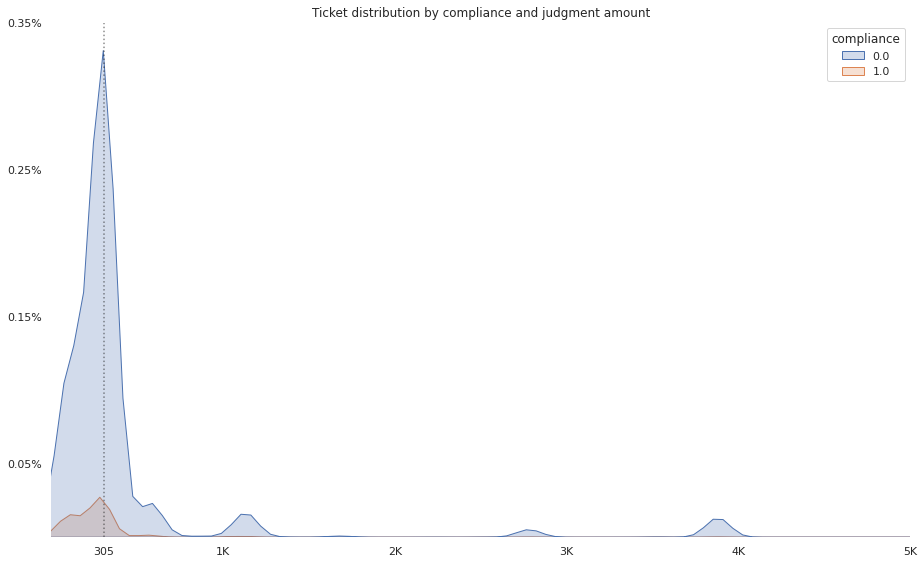

In [24]:
# Separating Training data by ticket compliance
mask = training_mapped_data.compliance==0
non_compliant = training_mapped_data[mask]
compliant = training_mapped_data[~mask]

fig, ax = plt.subplots(figsize = (13,8))
sns.kdeplot(data=training_mapped_data, 
            x="judgment_amount",
            hue="compliance",
            fill=True,
            ax=ax);

# Finishing
ax.set_xlim(0,5000);
ax.set(xlabel=None, ylabel=None)

ax.axvline(x = 305, color='k', linestyle=':', alpha=0.5)

ax.set_yticks([ax.get_yticks()[i] for i in [1,3,5,7]])
ylabels = [f'{y:,.2%}' for y in ax.get_yticks()]
ax.set_yticklabels(ylabels)

ax.set_xticks([305, 1000, 2000, 3000, 4000, 5000])
xlabels = [305]+[f'{int(x/1000)}K' for x in ax.get_xticks()[1:]]
ax.set_xticklabels(xlabels)

ax.set_title('Ticket distribution by compliance and judgment amount')
sns.despine(left = True, bottom = True)
fig.tight_layout()

The most frequent judgment amount is 305 for both compliant and non-compliant tickets.

## 2.7 Fee or discount <a id="2.7"></a> 
[Previous](#2.6) | [ToC](#ToC) | [Next](#2.8)

In [25]:
# Get count and mean compliance for training data 
fee_or_discount = training_mapped_data[['fee_or_discount', 'compliance']].groupby('fee_or_discount').agg(['mean', 'count'])
fee_or_discount = fee_or_discount.droplevel(0, axis='columns')

# Get count for test data
fee_or_discount = fee_or_discount.join(test_mapped_data.fee_or_discount.value_counts()).fillna(0)

# Renaming columns for plotting
fee_or_discount.rename(columns={'mean': 'training_compliance_rate',
                                'count': 'training_count',
                                'fee_or_discount': 'test_count'},
                       inplace=True)
fee_or_discount.test_count = fee_or_discount.test_count.astype('int32')

# Sorting columns in descending training count
fee_or_discount.sort_values('training_count', inplace=True, ascending=False)
fee_or_discount

,training_compliance_rate,training_count,test_count
fee_or_discount,,,
Late fee,0.041510,144422,52947
No modifier,0.313699,14278,7292
Discount,0.951695,1180,762


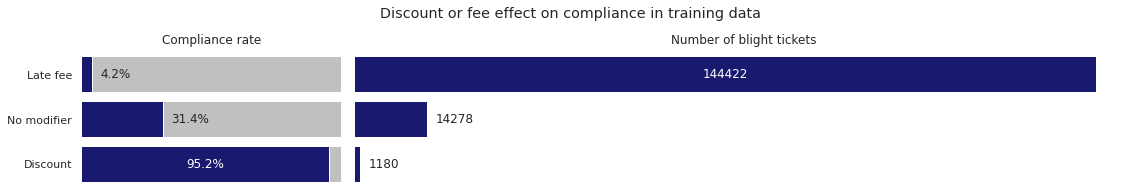

In [26]:
# Setting the plot figure
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(16,3),
                               gridspec_kw={'width_ratios': [1, 3]},
                               sharey=True)
fig.suptitle('Discount or fee effect on compliance in training data', y=0.9)

# First plot
first_bars_1 = ax1.barh(fee_or_discount.index[:-1],
                        100*fee_or_discount.training_compliance_rate[:-1],
                        facecolor=color)
first_bars_2 = ax1.barh(fee_or_discount.index[-1],
                        100*fee_or_discount.training_compliance_rate[-1],
                        facecolor=color)
ax1.barh(fee_or_discount.index, 
         100*(1-fee_or_discount.training_compliance_rate),
         left=100*fee_or_discount.training_compliance_rate,
         color='silver')

ax1.bar_label(first_bars_1, padding=8, fmt='%.1f%%')
ax1.bar_label(first_bars_2, label_type='center', fmt='%.1f%%', c='w')

ax1.get_xaxis().set_visible(False)
ax1.set_xlim(0,100)
ax1.set_title('Compliance rate')

# Second plot
second_bars_1 = ax2.barh(fee_or_discount.index[0],
                         fee_or_discount.training_count[0],
                         facecolor=color)
second_bars_2 = ax2.barh(fee_or_discount.index[1:],
                         fee_or_discount.training_count[1:],
                         facecolor=color)
ax2.invert_yaxis()
ax2.bar_label(second_bars_1, label_type='center', c='w')
ax2.bar_label(second_bars_2, padding=8)
ax2.get_xaxis().set_visible(False)
ax2.set_title('Number of blight tickets')

# Finishing
sns.despine(left = True, bottom = True)
plt.tight_layout()
plt.subplots_adjust(top=.7)

Tickets that received a discount are approximately three times more likely to be paid. When there is a fee, the chance drops significantly (26.8%). From the features selected, this seems the most impactful so far.

## 2.8 Latitude and Longitude <a id="2.8"></a> 
[Previous](#2.7) | [ToC](#ToC) | [Next](#3)

In this section we will analyse how compliance appears on map for training instances. Non-compliant and compliant tickets will be plotted separately to see how they are spread on the map. There is a clear concentration of tickets near the metropolitan area, despite the data set showing instances located far into non-metropolitan area.

For each compliance status, both the metropolitan and the full area maps will be displayed.

In [27]:
offset = 0.1 # Latitude and longitude offset for plotting purposes
quantile = 0.01 # Percentage of 'outer' locations to be disregarded

# Area comprised of ticket locations
bounding_box = (training_mapped_data.lon.min()-offset, training_mapped_data.lon.max()+offset,
                training_mapped_data.lat.min()-offset, training_mapped_data.lat.max()+offset)

# Selecting locations between quantile and 1-quantile
mask = (training_mapped_data.lon > training_mapped_data.lon.quantile(quantile))&\
       (training_mapped_data.lon < training_mapped_data.lon.quantile(1-quantile))&\
       (training_mapped_data.lat > training_mapped_data.lat.quantile(quantile))&\
       (training_mapped_data.lat < training_mapped_data.lat.quantile(1-quantile))

training_zoomed_data = training_mapped_data[mask]

# Bounding box reduced by quantile margins
zoomed_box = (training_zoomed_data.lon.min()-offset, training_zoomed_data.lon.max()+offset,
              training_zoomed_data.lat.min()-offset, training_zoomed_data.lat.max()+offset)

print(f'Bounding box: {bounding_box}\nZoomed box:{zoomed_box}')

Bounding box: (-84.5037662, -82.41293610000001, 42.045257, 44.8853893)
Zoomed box:(-83.3727309, -82.8329533, 42.189582, 42.545895)


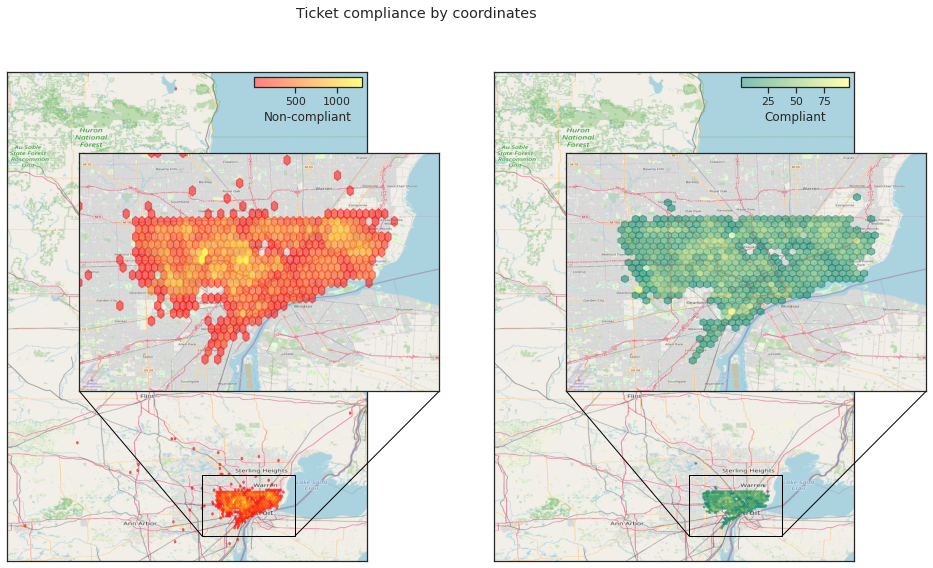

In [28]:
def hexbin_map(ax, image_path, box, data, gridsize, cmap):
    """Generates non-compliant tickets hexbin plots for both general and zoomed maps"""

    # Data can be either compliant or non-compliant
    hexbin = ax.hexbin(data.lon,
                       data.lat,
                       gridsize=gridsize,
                       mincnt=1,
                       alpha=0.5,
                       cmap=cmap)
    
    # Setting title and background map
    detroit_map = plt.imread('../input/detroit-blight-ticket/'+image_path)
    ax.imshow(detroit_map, zorder=0, extent = box, aspect= 'equal');

    # Setting
    ax.set_xlim(box[0],box[1])
    ax.set_ylim(box[2],box[3])
    
    # Hide axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    return hexbin
    
def inset_axis(ax, data, gridsize, cmap, title):
    """Nests zoomed map into full map"""
    
    # Plot main map
    main_map = hexbin_map(ax, 'All_tickets.png', bounding_box, data, gridsize, cmap)
    
    # Make auxiliary axis to insert colorbar
    colorbar_axis = inset_axes(ax,
                               width="30%",
                               height="2%",
                               loc="upper right")
    fig.colorbar(main_map,
                 cax=colorbar_axis,
                 orientation="horizontal",
                 label=title);
    
    # Create an inset axis in the bottom right corner
    ax_zoom = ax.inset_axes([0.20, 0.09, 1, 1])

    # Plot zoomed map
    hexbin_map(ax_zoom, 'zoomed_view.png', zoomed_box, data, gridsize, cmap)

    # Add the lines to indicate where the inset axis is coming from
    ax.indicate_inset_zoom(ax_zoom,
                           edgecolor='black',
                           alpha=1)

# Setting figure and plotting maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,9))
inset_axis(ax1, non_compliant, 200, 'autumn', 'Non-compliant')
inset_axis(ax2, compliant, 40, 'summer', 'Compliant')
fig.suptitle('Ticket compliance by coordinates')
plt.subplots_adjust(top=.88)

As previously noted, there are far more instances of non-compliant tickets. The highest non-compliant ticket concentration between the center and west. Another concentration can be seen northeast.

The concentration of compliant tickets roughly follows the non-compliant spread, but the highest concentration of compliant tickets can be observed south of the western non-compliant concentration.

# 3. Machine learning <a id="3"></a>
[Previous](#2.8) | [ToC](#ToC) | [Next](#3.1)

## 3.1 Predictor variables and target variable <a id="3.1"></a> 
[Previous](#3) | [ToC](#ToC) | [Next](#3.2)

In [29]:
# Training data variables
X = training_mapped_data[features]
y = training_mapped_data[target]

# Test data variable
Z = test_mapped_data[features]

## 3.2 Feature encoding <a id="3.2"></a> 
[Previous](#3.1) | [ToC](#ToC) | [Next](#3.3)

From the four categorical features (*violation_code_frequency*, *agency_name*, *disposition* and *fee_or_discount*), only the first can be considered ordinal, as its possible values follow a logical ordering. This feature will be encoded using *OrdinalEncoder* while the rest will be encoded using *OneHotEnconder*.

The three numerical features (*judgment_amount*, *lat*, *lon*) will be encoded using *MinMaxScaler*.

In [30]:
# Instantiating OneHotEncoder, OrdinalEncoder and MinMaxScaler
ohe = OneHotEncoder(sparse = False,
                    handle_unknown='ignore')
oe = OrdinalEncoder()
mms = MinMaxScaler()

features_ordinal = ['violation_code_frequency']
features_nominal = ['agency_name', 'disposition', 'fee_or_discount']

# Preprocessor to be used with classifiers to generate pipelines
preprocessor = ColumnTransformer([('one-hot-encoder', ohe, features_nominal),
                                  ('ordinal-encoder', oe, features_ordinal),
                                  ('min-max-scaler', mms, features_numerical)])

## 3.3 Data split <a id="3.3"></a> 
[Previous](#3.2) | [ToC](#ToC) | [Next](#3.4)

In [31]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (119910, 7)
Y_train shape:  (119910, 1)
X_test shape:  (39970, 7)
Y_test shape:  (39970, 1)


## 3.4 Model training and pipelines <a id="3.4"></a> 
[Previous](#3.3) | [ToC](#ToC) | [Next](#3.4.1)

The following subsections contain creation of pipelines for multiple classifiers. Each classifier will go through a grid search in order to maximize its AUC-ROC score, followed by model fitting. AUC-ROC scores are then determined and, in a later section, will then be compared to determine which one performed better.

### 3.4.1 K-nearest neighbors <a id="3.4.1"></a> 
[Previous](#3.4) | [ToC](#ToC) | [Next](#3.4.2)

Due to its simplicity, k-nearest neighbors classifier is a good starting point for comparing model performance. Every point in test set will be compared to its closest n training points in feature space. Each training point has a compliance status and a majority vote between these training neighbors will determine the test point compliance.

In [32]:
# Initialize classifiers dictionaries
classifiers = dict()

# Instantiate pipeline with KNeighbors classifier
knn = KNeighborsClassifier()
knn_pipeline = make_pipeline(preprocessor, knn)

In [33]:
# Grid search
# knn_parameters = {'kneighborsclassifier__n_neighbors': np.arange(1,501)}
# knn_grid = GridSearchCV(knn_pipeline, 
#                         knn_parameters, 
#                         scoring='roc_auc',
#                         verbose=3,
#                         n_jobs=-1)

# # Model training
# knn_grid.fit(X_train, np.ravel(y_train));

# print('Grid best parameter (max. AUC): ', knn_grid.best_params_)
# print('Grid best score (AUC): ', knn_grid.best_score_)

# Output for kneighborsclassifier__n_neighbors': np.arange(1,101)
# Grid best parameter (max. AUC):  {'kneighborsclassifier__n_neighbors': 97}
# Grid best score (AUC):  0.799282988987459

# Output for kneighborsclassifier__n_neighbors': np.arange(1,501)
# Grid best parameter (max. AUC):  {'kneighborsclassifier__n_neighbors': 237}
# Grid best score (AUC):  0.8032513935833354

In [34]:
# Set optimal parameters found in GridSearchCV
knn_pipeline.set_params(**{'kneighborsclassifier__n_neighbors':237})

# Model training
knn_pipeline.fit(X_train, np.ravel(y_train));

# Decision function and True/False positive rate
y_score_knn = knn_pipeline.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Save properties
classifiers['k-Nearest Neighbors'] = [fpr_knn, tpr_knn, roc_auc_knn]

### 3.4.2 Logistic regression <a id="3.4.2"></a> 
[Previous](#3.4.1) | [ToC](#ToC) | [Next](#3.4.3)

The logistic regression classifier will try and determine a decision boundaries that separates the feature space in two, based on the probability of compliance. For example, test set points situated in the space reserved for probability of convergence less than 50% will be considered non-compliant.

The SAGA solver was chosen for this classifier because of its convergence. Paired with a large max iterations value, this solver converges both faster and more often compared to the standard L-BFGS solver. Besides that, the SAGA solver allows for the chosing of both L1 and L2 regularization penalties, which will be one of the parameters during grid search.

In [35]:
# Instantiate pipeline with LogisticRegression classifier
lr = LogisticRegression(solver='saga', max_iter = 4000, random_state=0)
lr_pipeline = make_pipeline(preprocessor, lr)

In [36]:
# # Grid search
# lr_parameters = {"logisticregression__C" : np.logspace(-3, 3, 7),
#                  "logisticregression__penalty" : ["l1", "l2"]}
# lr_grid = GridSearchCV(lr_pipeline,
#                        lr_parameters,
#                        scoring='roc_auc',
#                        verbose=3,
#                        n_jobs=-1)

# # Model training
# lr_grid.fit(X_train, np.ravel(y_train));

# print('Grid best parameter (max. AUC): ', lr_grid.best_params_)
# print('Grid best score (AUC): ', lr_grid.best_score_)

# Output for {"logisticregression__C" : np.logspace(-3, 3, 7), 'logisticregression__penalty" : ["l1", "l2"]}
# Grid best parameter (max. AUC):  {'logisticregression__C': 1000.0, 'logisticregression__penalty': 'l1'}
# Grid best score (AUC):  0.7882938483322776

In [37]:
# Set optimal parameters found in GridSearchCV
lr_pipeline.set_params(**{'logisticregression__C': 1000.0, 
                          'logisticregression__penalty': 'l1'})

# Model training
lr_pipeline.fit(X_train, np.ravel(y_train));

# Decision function and True/False positive rate
y_score_lr = lr_pipeline.decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Save properties
classifiers['Logistic Regression'] = [fpr_lr, tpr_lr, roc_auc_lr]

### 3.4.3 Support vector machine <a id="3.4.3"></a> 
[Previous](#3.4.2) | [ToC](#ToC) | [Next](#3.4.4)

Although the method diverges from the logistic regression, support vector machines tries to find a decision boundary for compliance status in feature space. The strategy is to reward the best model settings that maximizes classifier margin, i.e. the distance between training points and the decision boundary.

In [38]:
# Instantiate pipeline with SVM classifier
svm = SVC(random_state=False)
svm_pipeline = make_pipeline(preprocessor, svm)

In [39]:
# # Grid search
# svm_parameters = {'svc__C': [0.1, 1, 10, 100, 1000], 
#                   'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#                   'svc__kernel': ['linear', 'rbf']}
# svm_grid = GridSearchCV(svm_pipeline, 
#                         svm_parameters, 
#                         scoring='roc_auc',
#                         verbose=3,
#                         n_jobs=-1)

# # Model training
# svm_grid.fit(X_train, np.ravel(y_train));

# print('Grid best parameter (max. AUC): ', svm_grid.best_params_)
# print('Grid best score (AUC): ', svm_grid.best_score_)

# #Output for svm_parameters = {'svc__C': [0.1, 1, 10, 100, 1000], 
#                               'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#                               'svc__kernel': ['linear', 'rbf']}
# Grid best parameter (max. AUC):  {'svc__C': 1000, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
# Grid best score (AUC):  0.7934360195674861

In [40]:
# Set optimal parameters found in GridSearchCV
svm_pipeline.set_params(**{'svc__C': 1000,
                           'svc__gamma': 0.01,
                           'svc__kernel': 'rbf'})

# Model training
svm_pipeline.fit(X_train, np.ravel(y_train));

# Decision function and True/False positive rate
y_score_svm = svm_pipeline.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Save properties
classifiers['Support Vector Machine'] = [fpr_svm, tpr_svm, roc_auc_svm]

### 3.4.4 Random forests <a id="3.4.4"></a> 
[Previous](#3.4.3) | [ToC](#ToC) | [Next](#3.5)

Decision trees are flexible and a good exploratory method to investigate feature importance, but a single decision tree is prone to overfitting.
Instead, using random forests can help stability and generate better generalization.

In [41]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=10000)
rf_pipeline = make_pipeline(preprocessor, rf)
rf_pipeline.fit(X_train, np.ravel(y_train))

# Decision function and True/False positive rate
y_score_rf = rf_pipeline.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Save properties
classifiers['Random forests'] = [fpr_rf, tpr_rf, roc_auc_rf]

## 3.5 Feature importance <a id="3.5"></a> 
[Previous](#3.4.4) | [ToC](#ToC) | [Next](#3.6)

One of the most useful characteristics of random forests is to evaluate the importance of the features previously chosen. This importance represents how relevant it was for the classification task. 

In [42]:
# After One-hot-encoding, 11 new features (leave one out) are created
feature_ohe = rf_pipeline['columntransformer'].transformers_[0][1].get_feature_names_out(features_nominal)
feature_names = feature_ohe.tolist()+features_ordinal+features_numerical

# Get feature importance scores
feature_scores = rf_pipeline['randomforestclassifier'].feature_importances_

# Combining them in one series
feature_importances = pd.Series(feature_scores, index=feature_names, name='Importance')

# Aggregating some statistics into the original 7 features
name_mapper = {'violation_code_frequency': 'Violation code',
               'lon': 'Longitude',
               'lat': 'Latitude',
               'fee_or_discount_': 'Fee or discount',
               'disposition_': 'Disposition',
               'judgment_amount': 'Judgment amount',
               'agency_name': 'Agency name'}

def feature_mapper(feature:str):
    for key in name_mapper:
        if key in feature:
            return name_mapper[key]
    
feature_importances.index = feature_importances.index.map(feature_mapper)
feature_importances = feature_importances.groupby(feature_importances.index).agg('sum').sort_values(ascending=False)

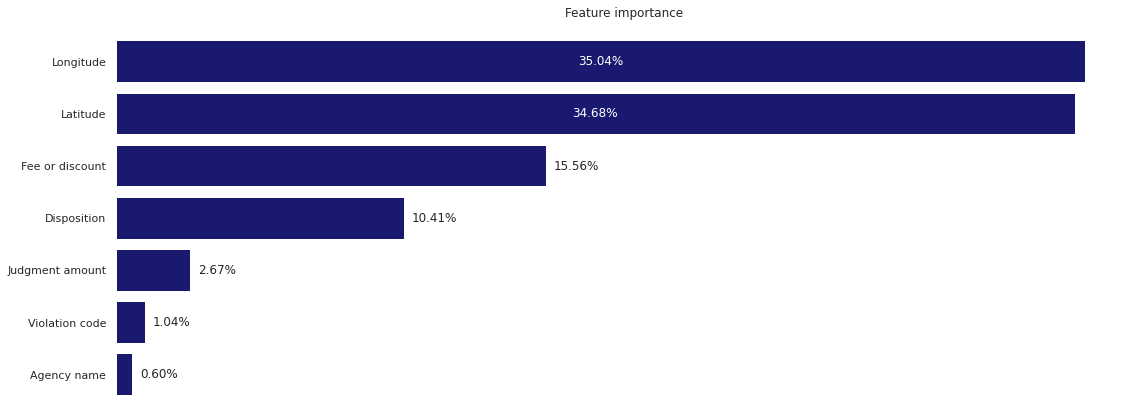

In [43]:
# Setting the plot figure
fig, ax = plt.subplots(figsize=(16,6))

# Bar plot
bar_1 = ax.barh(feature_importances.index[:2], 
                feature_importances[:2]*100,
                facecolor=color)
bar_2 = ax.barh(feature_importances.index[2:], 
                feature_importances[2:]*100,
                facecolor=color)
ax.invert_yaxis()
# ax.bar_label(bar_1, label_type='center', c='w')
# ax.bar_label(bar_2, padding=8)
ax.get_xaxis().set_visible(False)
ax.set_title('Feature importance')

ax.bar_label(bar_2, padding=8, fmt='%.2f%%')
ax.bar_label(bar_1, label_type='center', fmt='%.2f%%', c='w')

# Finishing
sns.despine(left = True, bottom = True)
plt.tight_layout()

Geographical features appear as the most relevant in determing ticket compliance. Latitude and longitude combined they represent 69.72% of feature importance. Fee or discount appear as an important feature (15.56%) as suggested in EDA section. Disposition follows with 10.41%.

Intuitively, judgment amount would thought as a relevant feature to ticket compliance, but only scores 2.67% feature importance. Violation code and agency name together sum 1,64% and appear as the least relevant features.

## 3.6 ROC curve <a id="3.6"></a> 
[Previous](#3.5) | [ToC](#ToC) | [Next](#3.7)

Plotting ROC curves for all classifiers and comparing their AUC-ROC will help to select the optimal model.

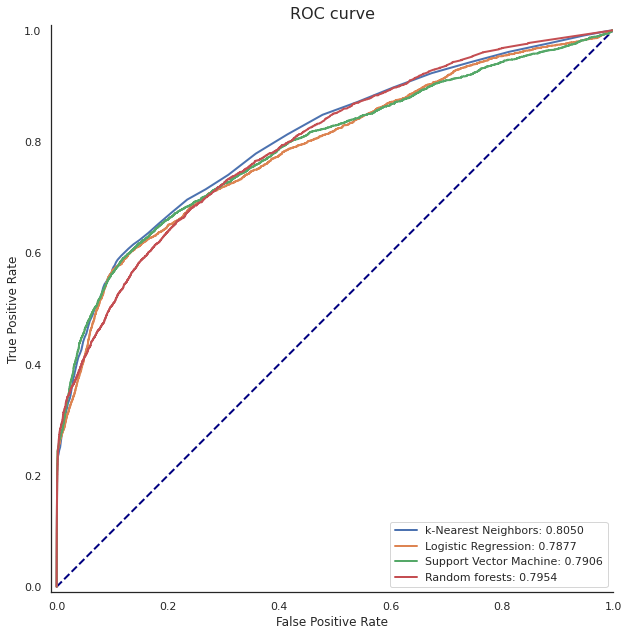

In [44]:
# Setting plot figure
fig = plt.figure(figsize = (9,9))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve', fontsize=16)

# Reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');

# ROC curve for each model in classifiers
for classifier, attributes in classifiers.items():
    plt.plot(attributes[0], attributes[1], lw=2, 
             label=f'{classifier}: {attributes[2]:0.4f}')
    
# Finishing
plt.gca().set_aspect('equal')
plt.legend(loc="lower right", fontsize=11)
sns.despine()
plt.tight_layout()

k-Nearest Neighbors was the classifier that presented the best AUC-ROC.

## 3.7 Applying best classifier to test data <a id="3.7"></a> 
[Previous](#3.6) | [ToC](#ToC) | [Next](#4)

Now that a classifier has been chosen, we can use it to calculate the probability that each corresponding ticket from test set will be paid.

In [45]:
result = pd.Series(knn_pipeline.predict_proba(Z)[:,1], index = Z.index)
result

ticket_id
284932    0.063291
285362    0.021097
285361    0.046414
285338    0.046414
285346    0.084388
            ...   
376496    0.004219
376497    0.004219
376499    0.063291
376500    0.063291
369851    0.455696
Length: 61001, dtype: float64

# 4. Conclusion  <a id="4"></a>
[Previous](#3.7) | [ToC](#ToC)

This study goes through the many steps of machine learning. From preprocessing unbalanced data sets to selecting the best classifier for this task - in this case AUC-ROC.

The more complex classifiers showed a performance above the expected AUC-ROC score defined at the beggining of the study, but it was the often considered simplest classifier k-nearest neighbors that showed the best score. This goes to show that machine learning helps us identify elements that at first seemingly had no relevance in target determination and that more sofisticated models do not necessarily mean better scores.

From the manually selected features, some such as violation code and agency name showed little relevance as to predict ticket compliance. Not intuitively, latitude and longitude seemed to be the most relevant features. One hyphotesis that would be interesting to investigate is how these geographical variables are related to socioeconomic factors of a given city region.